# Imports

Libraries:
-Numpy
-Pandas
-Tensorflow
-sklearn
-matplotlib
-datetime
-time

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from numpy import array
from sklearn.metrics import root_mean_squared_error,mean_absolute_error #If you encounter an Import Error here, you will need to update scikit-learn.
from math import sqrt
tf.random.set_seed(42)
np.random.seed(42)
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Dropout
from keras.utils import plot_model
from keras.layers import SimpleRNN
from keras.optimizers import Adam
from keras.layers import LSTM, Input
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
# from scikeras.wrappers import KerasRegressor #Incompatible with tensorflow 2.10.0 and many other dependencies
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
import time

## Data preprocessing

### Downloading

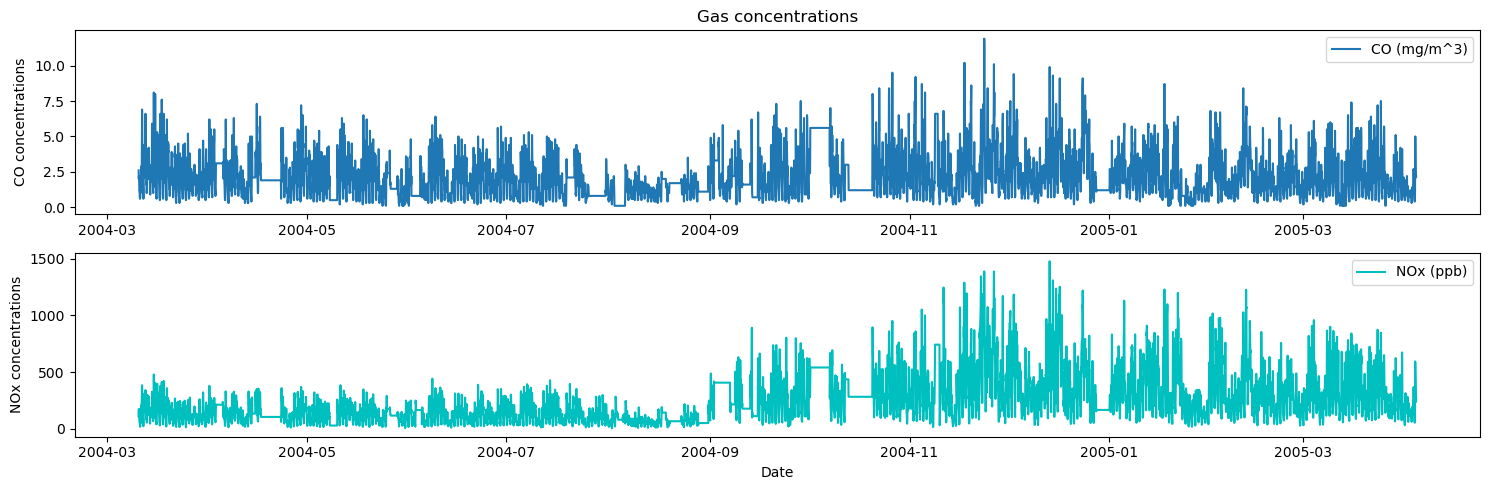

In [5]:
df= pd.read_csv("AirQualityUCI (Seperated).csv")
df = df.drop(df.columns[-2:], axis=1)
df.dropna(axis=0, how='any', inplace=True)
df['date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index('date')
df.replace(-200, np.nan, inplace=True)
df_ff = df.ffill()
data=df_ff[['CO(GT)','NOx(GT)']]
# print("Missing values in each column:\n", data.isna().sum())
# data.head()
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.plot(data['CO(GT)'], label='CO (mg/m^3)')
plt.ylabel('CO concentrations')
plt.title('Gas concentrations')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['NOx(GT)'],label='NOx (ppb)',color='c')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')
plt.legend()

plt.tight_layout()

### Scaling and Splitting

In [6]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

In [7]:
train, test = train_test_split(scaled_data, test_size=0.2, shuffle=False)
print(f'Training Data Size: {len(train)}')
print(f'Testing Data Size: {len(test)}')

Training Data Size: 7485
Testing Data Size: 1872


In [8]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence.iloc[i:end_ix], sequence.iloc[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y) 

In [9]:
n_steps=24
X_train, y_train = split_sequence(train, n_steps)
X_test, y_test = split_sequence(test, n_steps)
print(X_train.shape)
print(y_train.shape)

# print(X_test.shape)
# print(y_test.shape)

(7461, 24, 2)
(7461, 2)


In [10]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# print(n_timesteps)
# print(n_features)
# print(n_outputs)

<font size="6">MUST RESTART KERNEL EVERY TIME YOU TRAIN A NETWORK TO ENSURE EVERYTHING WORKS PROPERLY</font>

# LSTM

### Training

In [11]:
def build_lstm_model(n_timesteps, n_features, n_outputs, lr):
    model = Sequential()
    model.add(LSTM(60, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(LSTM(36, activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

param_grid = {
    'lr': [1e-3, 1e-2],          # Learning rates
    'batch_size': [32, 48],       # Batch sizes
    'epochs': [25, 50],          # Number of epochs
}


# K-fold cross-validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Perform manual grid search
best_score = float('inf')
best_params = None

start_lstm=time.time()

for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            fold_scores = []
            
            for train_index, val_index in kf.split(X_train):
                # Split the data
                X_comp, X_val = X_train[train_index], X_train[val_index]
                y_comp, y_val = y_train[train_index], y_train[val_index]
                
                # Build the model
                model = build_lstm_model(n_timesteps, n_features, n_outputs, lr)
                
                # Train the model
                history = model.fit(
                    X_comp, y_comp,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1
                )
                
                # Evaluate the model on validation data
                val_loss = model.evaluate(X_val, y_val, verbose=0)
                fold_scores.append(val_loss)
            
            # Calculate average score across folds
            mean_score = np.mean(fold_scores)
            
            # Update best score and params
            if mean_score < best_score:
                best_score = mean_score
                best_params = {
                    'lr': lr,
                    'batch_size': batch_size,
                    'epochs': epochs,
                }

            # Print progress
            print(f"Params: lr={lr}, batch_size={batch_size}, epochs={epochs} -> Mean Loss: {mean_score}")


# Output the best parameters
print("Best Params:", best_params)
print("Best Validation Loss:", best_score)

end_lstm=time.time()
time_lstm=(end_lstm-start_lstm)/60
print(f"Elapsed time: {time_lstm:.4f} minutes")

Epoch 1/25
117/117 [==============================] - 5s 25ms/step - loss: 0.0279 - val_loss: 0.0257
Epoch 2/25
117/117 [==============================] - 3s 22ms/step - loss: 0.0267 - val_loss: 0.0256
Epoch 3/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0258 - val_loss: 0.0239
Epoch 4/25
117/117 [==============================] - 3s 21ms/step - loss: 0.0247 - val_loss: 0.0235
Epoch 5/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0241 - val_loss: 0.0234
Epoch 6/25
117/117 [==============================] - 3s 22ms/step - loss: 0.0237 - val_loss: 0.0231
Epoch 7/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0233 - val_loss: 0.0230
Epoch 8/25
117/117 [==============================] - 3s 22ms/step - loss: 0.0234 - val_loss: 0.0223
Epoch 9/25
117/117 [==============================] - 3s 23ms/step - loss: 0.0231 - val_loss: 0.0227
Epoch 10/25
117/117 [==============================] - 3s 22ms/step - loss: 0.0231 - val_lo

In [14]:
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
model_lstm_best = build_lstm_model(n_timesteps, n_features, n_outputs, best_lr)
model_lstm_best.fit(X_train, y_train,epochs=best_epochs,batch_size=best_batch_size,verbose=1)

Epoch 1/50
234/234 [==============================] - 6s 15ms/step - loss: 0.0134
Epoch 2/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0064
Epoch 3/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0040
Epoch 4/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0037
Epoch 5/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0032
Epoch 6/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0033
Epoch 7/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0031
Epoch 8/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0030
Epoch 9/50
234/234 [==============================] - 3s 15ms/step - loss: 0.0030
Epoch 10/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0029
Epoch 11/50
234/234 [==============================] - 4s 16ms/step - loss: 0.0029
Epoch 12/50
234/234 [==============================] - 4s 15ms/step - loss: 0.0028
Epoch 13/50
2

### Testing

58/58 [==============================] - 0s 7ms/step
RMSE for CO: 0.6275035605954892
MAE for CO: 0.4474173093529104
RMSE for NOx: 92.01134820270833
MAE for NOx: 64.78686098825364


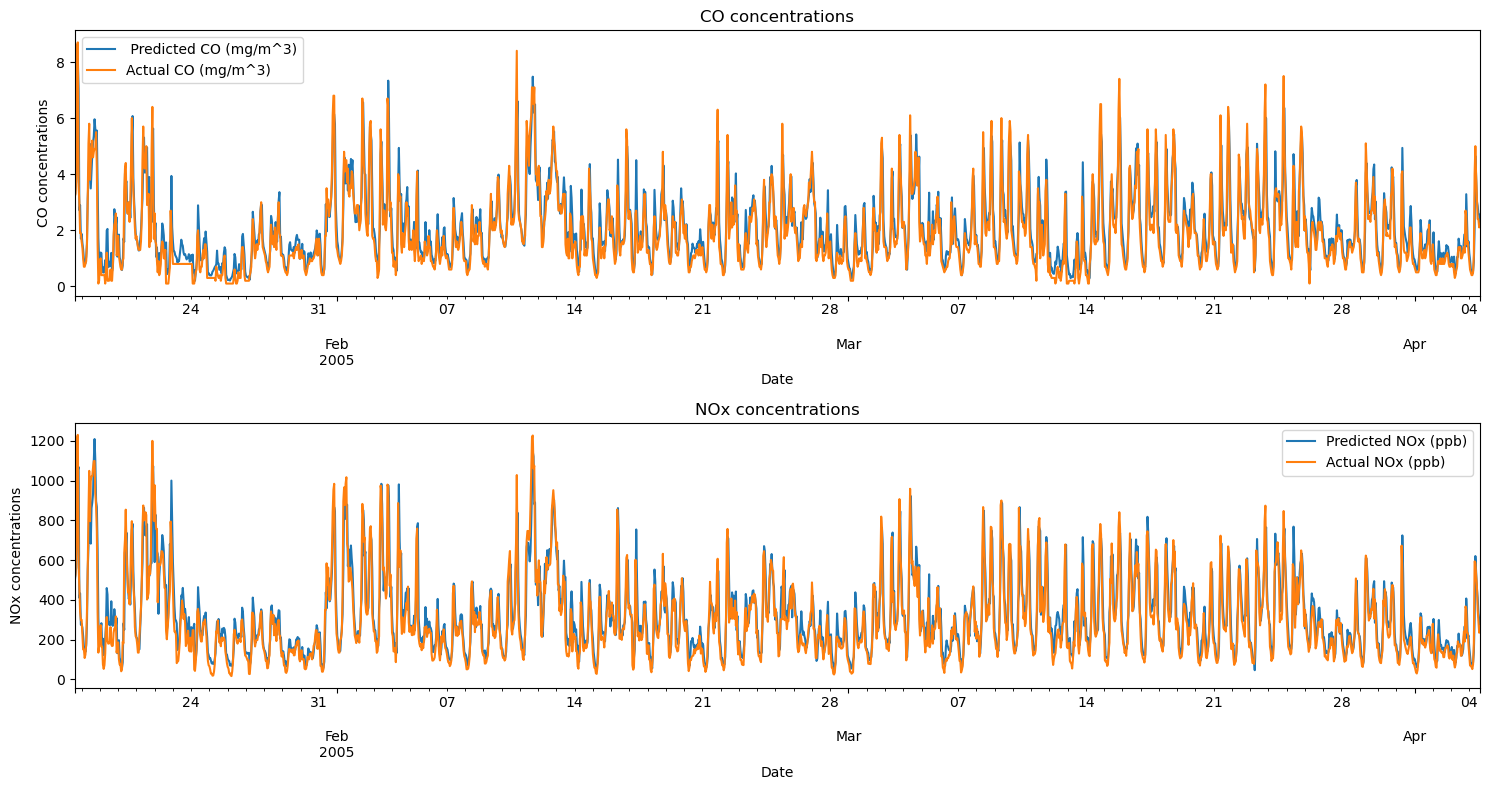

In [18]:
# Get the predictions for the test set
pred_LSTM = model_lstm_best.predict(X_test).flatten()
pred_LSTM = scaler.inverse_transform(pred_LSTM.reshape(-1, n_outputs))
pred_LSTM=pd.DataFrame(pred_LSTM, columns=['Pred_CO', 'Pred_NOx'])
valid_test=scaler.inverse_transform(test[n_timesteps:]) #New time series to accomodate 10 day lag between predictions and testing data
valid_test = pd.DataFrame(valid_test, columns=test[n_timesteps:].columns, index=test[n_timesteps:].index)
pred_LSTM.index=valid_test.index

rmse_LSTM_co=root_mean_squared_error(pred_LSTM['Pred_CO'],valid_test['CO(GT)'])
print('RMSE for CO: '+str(rmse_LSTM_co))
mae_LSTM_co=mean_absolute_error(pred_LSTM['Pred_CO'],valid_test['CO(GT)'])
print('MAE for CO: '+str(mae_LSTM_co))

rmse_LSTM_nox=root_mean_squared_error(pred_LSTM['Pred_NOx'],valid_test['NOx(GT)'])
print('RMSE for NOx: '+str(rmse_LSTM_nox))
mae_LSTM_nox=mean_absolute_error(pred_LSTM['Pred_NOx'],valid_test['NOx(GT)'])
print('MAE for NOx: '+str(mae_LSTM_nox))

plt.figure(figsize=(15, 8))
# Same plot
plt.subplot(2,1,1)
pred_LSTM['Pred_CO'].plot(title= 'CO concentrations',legend=True, label=' Predicted CO (mg/m^3)')
valid_test['CO(GT)'].plot(legend=True, label='Actual CO (mg/m^3)')
plt.xlabel('Date')
plt.ylabel('CO concentrations')


plt.subplot(2,1,2)
pred_LSTM['Pred_NOx'].plot(title= 'NOx concentrations',legend=True, label='Predicted NOx (ppb)')
valid_test['NOx(GT)'].plot(legend=True, label='Actual NOx (ppb)')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')

plt.tight_layout()

### Predicting

In [19]:
n_predictions = 8760  # Total number of hours to predict (8760 for full year)
start=y_test[-n_timesteps:] #Last 24 hrrs of data

# Initialize predictions list
predictions_lstm = np.empty((0,2))
predictions_lstm=np.append(predictions_lstm,start,axis=0)
window = start.reshape(1,n_timesteps,n_outputs)

print('Starting predictions:')
# Iteratively predict one timestep at a time
for k in range(n_predictions):
    # Predict the next timestep (24 hour)
    next_value = model_lstm_best.predict(window, verbose=False)
    noise=next_value * 0.1 * np.random.uniform(-1, 1, size=next_value.shape)
    next_value=next_value+noise
    # Append the prediction to the results
    predictions_lstm=np.append(predictions_lstm,next_value,axis=0)

    # Update the sliding window: Move the range to the last 24 values of predictions
    window = predictions_lstm[-n_timesteps:].reshape(1,n_timesteps,n_outputs)
    print('Day: '+ str(int(k/24)) + ' Hour: '+ str(k%24))

true_predictions_lstm=scaler.inverse_transform(predictions_lstm)
true_predictions_lstm=pd.DataFrame(true_predictions_lstm[n_timesteps:,:],columns=['Future CO (mg/m^3)', 'Future NOx (ppb)'])

start_time = datetime(2005, 4, 4, 15, 0, 0)
end_time = start_time + timedelta(hours=n_predictions-1)
index_future_dates=pd.date_range(start=start_time,end=end_time, freq='h')
true_predictions_lstm.index=index_future_dates
true_predictions_lstm.tail(5)

Starting predictions:
Day: 0 Hour: 0
Day: 0 Hour: 1
Day: 0 Hour: 2
Day: 0 Hour: 3
Day: 0 Hour: 4
Day: 0 Hour: 5
Day: 0 Hour: 6
Day: 0 Hour: 7
Day: 0 Hour: 8
Day: 0 Hour: 9
Day: 0 Hour: 10
Day: 0 Hour: 11
Day: 0 Hour: 12
Day: 0 Hour: 13
Day: 0 Hour: 14
Day: 0 Hour: 15
Day: 0 Hour: 16
Day: 0 Hour: 17
Day: 0 Hour: 18
Day: 0 Hour: 19
Day: 0 Hour: 20
Day: 0 Hour: 21
Day: 0 Hour: 22
Day: 0 Hour: 23
Day: 1 Hour: 0
Day: 1 Hour: 1
Day: 1 Hour: 2
Day: 1 Hour: 3
Day: 1 Hour: 4
Day: 1 Hour: 5
Day: 1 Hour: 6
Day: 1 Hour: 7
Day: 1 Hour: 8
Day: 1 Hour: 9
Day: 1 Hour: 10
Day: 1 Hour: 11
Day: 1 Hour: 12
Day: 1 Hour: 13
Day: 1 Hour: 14
Day: 1 Hour: 15
Day: 1 Hour: 16
Day: 1 Hour: 17
Day: 1 Hour: 18
Day: 1 Hour: 19
Day: 1 Hour: 20
Day: 1 Hour: 21
Day: 1 Hour: 22
Day: 1 Hour: 23
Day: 2 Hour: 0
Day: 2 Hour: 1
Day: 2 Hour: 2
Day: 2 Hour: 3
Day: 2 Hour: 4
Day: 2 Hour: 5
Day: 2 Hour: 6
Day: 2 Hour: 7
Day: 2 Hour: 8
Day: 2 Hour: 9
Day: 2 Hour: 10
Day: 2 Hour: 11
Day: 2 Hour: 12
Day: 2 Hour: 13
Day: 2 Hour: 14


Future CO (mg/m^3)  Future NOx (ppb)
2006-04-04 10:00:00            7.293653        669.601567
2006-04-04 11:00:00            7.252953        659.405573
2006-04-04 12:00:00            6.747847        653.853806
2006-04-04 13:00:00            6.500155        554.234406
2006-04-04 14:00:00            5.500313        593.124171

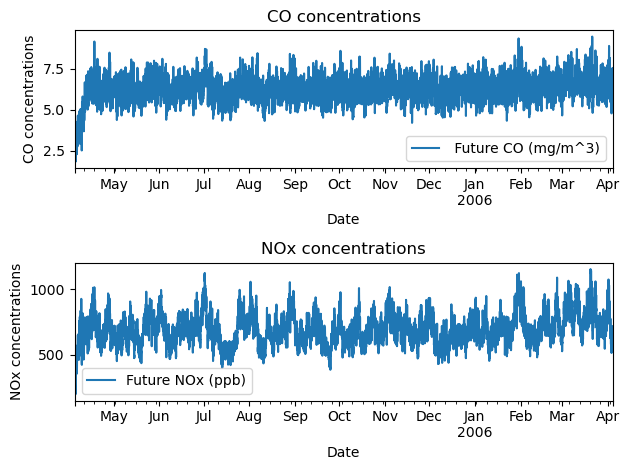

In [20]:
plt.subplot(2,1,1)
true_predictions_lstm['Future CO (mg/m^3)'].plot(title= 'CO concentrations',legend=True, label=' Future CO (mg/m^3)')
plt.xlabel('Date')
plt.ylabel('CO concentrations')


plt.subplot(2,1,2)
true_predictions_lstm['Future NOx (ppb)'].plot(title= 'NOx concentrations',legend=True, label='Future NOx (ppb)')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')

plt.tight_layout()

In [22]:
true_predictions_lstm.index.name='Date'
true_predictions_lstm.to_csv("LSTM predictions (GridSearch).csv", index=True)